## Levatamos Fermionic

In [2]:
import numpy as np
import openfermion as of
from tqdm import tqdm
from itertools import combinations
from openfermion.utils import commutator, count_qubits, hermitian_conjugated
import functools
import concurrent.futures
from numba import njit
import tensorflow as tf
import scipy
import sparse
import itertools
import linecache
from multiprocessing import Pool, cpu_count
import sympy

# Generación de base
class fixed_basis:
    @staticmethod
    def int_to_bin(k, d):
        return np.base_repr(k, 2).zfill(d)[::-1]  

    @staticmethod
    def bin_to_op(b):
        tups = [(i, 1) for i, k in list(enumerate(list(b))) if k == '1']
        return of.FermionOperator(tups)

    def idx_to_repr(self, idx):
        return self.canonicals[idx]

    def opr_to_idx(self, opr):
        for i in range(self.size): # Evitar esto ordenando opr
            if self.base[i] == opr:
                return i
                
    def op_to_idx(self, op):
        # Normalizamos el orden
        op = of.transforms.normal_ordered(op)
        # Si es nulo, devolvemos None
        if len(op.terms) == 0:
            return None
        act_lvls = lambda tt: [tpl[0] for tpl in next(iter(tt.terms.keys()))] # Consistente con lo anterior
        act = act_lvls(op)
        act_to_int = lambda x: np.sum([2**i for i in x])
        search = np.where(self.num_ele == act_to_int(act))[0]
        if search.size == 0:
            return None
        else:
            return search[0]

    # Calcula el valor medio a partir del indice del vector y el operador
    def idx_mean_val(self, idx: int, op: of.FermionOperator):
        vec = self.idx_to_repr(idx)
        return np.real(np.transpose(vec) @ of.get_sparse_operator(op, n_qubits=self.d) @ vec)

    # Calcula el valor medio a partir de un estado y el operador
    def mean_val(self, vec, op):
        idx = self.opr_to_idx(vec)
        return self.idx_mean_val(idx, op)

    # Calcula la contracción de un operador sobre dos estados dados
    def idx_contraction(self, idx_1, idx_2, op):
        rep = lambda x: self.idx_to_repr(x)
        return np.real(np.transpose(rep(idx_1)) @ of.get_sparse_operator(op, n_qubits=self.d) @ rep(idx_2))

    def create_basis(self, d, num = None, pairs = False):
        basis = []
        num_ele = []
        for k in range(0,2**d):
            b = self.int_to_bin(k, d)
            if num != None:
                if b.count('1') == num:
                    if pairs:
                        if np.all(b[::2] == b[1::2]):
                            oper = self.bin_to_op(b)
                            basis.append(oper)
                            num_ele.append(k)
                    else:
                        oper = self.bin_to_op(b)
                        basis.append(oper)
                        num_ele.append(k)
            else:
                oper = self.bin_to_op(b)
                basis.append(oper)
        return basis, num_ele

    def __init__(self, d, num = None, pairs = False, basis = None, num_ele = None):
        self.d = d
        self.num = num
        self.m = num
        # Si nos da la base, la levantamos (asumimos GC). Si no, la creamos
        if basis is None:
            self.base, self.num_ele = self.create_basis(d, num, pairs)
        else:
            self.base, self.num_ele = basis, num_ele
        self.size = len(self.base)
        self.canonicals = np.eye(self.size)
        self.pairs = pairs

    @staticmethod
    def cdc(i, j):
        return of.FermionOperator(((i,1),(j,0)))

    @staticmethod
    def cc(i, j):
        return of.FermionOperator(((i,0),(j,0)))

    # Del indice, cuenta el número de partículas
    def num_idx(self, idx):
        b = self.int_to_bin(idx, basis.d)
        return b.count('1')

    # Calculo de rho1 (via directa, lento, y solo definido en la base por ahora)
    def rho_1(self, op):
        # Necesitamos un índice, es?
        if type(op) != int:
            op = self.opr_to_idx(op)
        mat = np.zeros((self.d, self.d))
        for i in range(self.d):
            for j in range(self.d):
                cdc = self.cdc(j, i)
                mat[i,j] = self.idx_mean_val(op, cdc)
        return mat

# Calculo de generadores de rho1
def rho_1_gen(basis):
    # Vamos a crear un hipersparse de TF, almacenamos los valores acá
    indices = []
    values = []
    shape = (basis.d, basis.d, basis.size, basis.size)
    d = basis.d
    for i in tqdm(range(0, d)):
        for j in range(0, d):
            # Generamos el operador
            op = basis.cdc(j, i)
            #print(op)
            if basis.num == None:
                mat = np.real(of.get_sparse_operator(op, n_qubits=d))
            else:
                mat = np.real(of.get_sparse_operator(op, n_qubits=d))[np.ix_(basis.num_ele, basis.num_ele)]
            # Extraemos la información
            n_r, n_c = mat.nonzero()
            data = mat.data
            for r, c, v in zip(n_r, n_c, data):
                indices.append([i, j, r, c])
                values.append(v)
    indices_t = np.array(indices).T
    s_t = sparse.COO(indices_t, values, shape=shape)
    return s_t

# Calculo de rho1 (via generadores) de un vector en la base canonica
def rho_1(vect, rho_1_arrays):
    if len(vect.shape) == 1: # vectores
        return sparse.einsum('k,ijkl,l->ij', vect, rho_1_arrays, vect)
    elif len(vect.shape) == 2: # mat densidad
        return sparse.einsum('ijkl,kl->ij', rho_1_arrays, vect)
    else: # mat densidad batcheadas
        return sparse.einsum('bkl,ijkl->bij', vect, rho_1_arrays)

# Calculo de indices de rho2kkbar
def get_kkbar_indices(t_basis):
    indices = []
    for i, ind in enumerate(t_basis.num_ele):
        v = t_basis.int_to_bin(ind, t_basis.d)
        if np.all(v[::2] == v[1::2]):
            indices.append(i)
    return indices

# Calculo de generadores de rho2
def rho_2_gen(basis, t_basis, idx_list = []):
    # Vamos a crear un hipersparse de TF, almacenamos los valores acá
    d = basis.d
    indices = []
    values = []
    if len(idx_list) == basis.m:
        idx_list = idx_list
    elif len(idx_list) == basis.m**4:
        idx_list = np.unique(idx_list[:,0])
    else:
        idx_list = range(t_basis.size)
    shape = (len(idx_list), len(idx_list), basis.size, basis.size)
    for i, ii in tqdm(enumerate(idx_list), total=len(idx_list)):
        for j, jj in enumerate(idx_list):
            # Generamos el operador
            op = t_basis.base[jj]*of.utils.hermitian_conjugated(t_basis.base[ii])
            if basis.num == None:
                mat = np.real(of.get_sparse_operator(op, n_qubits=d))
            else:
                mat = np.real(of.get_sparse_operator(op, n_qubits=d))[np.ix_(basis.num_ele, basis.num_ele)]
            # Extraemos la información
            n_r, n_c = mat.nonzero()
            data = mat.data
            for r, c, v in zip(n_r, n_c, data):
                indices.append([i, j, r, c])
                values.append(v)

    indices_t = np.array(indices).T
    s_t = sparse.COO(indices_t, values, shape=shape)
    return s_t

# rho_m_gen aux func
def process_chunk(args):
    chunk, m_basis, basis, d, it_set = args
    indices = []
    values = []
    for ii in chunk:
        for jj in it_set:
            # Generate the operator
            op = m_basis.base[jj] * of.utils.hermitian_conjugated(m_basis.base[ii])
            mat = np.real(of.get_sparse_operator(op, n_qubits=d))[np.ix_(basis.num_ele, basis.num_ele)]
            # Extract the information
            n_r, n_c = mat.nonzero()
            data = mat.data
            for r, c, v in zip(n_r, n_c, data):
                indices.append([ii, jj, r, c])
                values.append(v)
    return indices, values

# Parallelized rho_m_gen
def rho_m_gen(basis, m, num_workers=None):
    if num_workers is None:
        num_workers = cpu_count()  # Use all available CPUs by default
    
    indices = []
    values = []
    m_basis = fixed_basis(basis.d, num=m, pairs=basis.pairs)
    shape = (m_basis.size, m_basis.size, basis.size, basis.size)

    it_set = np.arange(m_basis.size)
    chunks = np.array_split(it_set, num_workers)  # Split `it_set` into chunks for each worker

    # Use multiprocessing Pool for parallel processing
    with Pool(processes=num_workers) as pool:
        # Pass arguments as tuples instead of using a lambda
        results = list(
            tqdm(
                pool.imap(
                    process_chunk, 
                    [(chunk, m_basis, basis, basis.d, it_set) for chunk in chunks]
                ),
                total=num_workers
            )
        )
    
    # Collect results from all processes
    for indices_chunk, values_chunk in results:
        indices.extend(indices_chunk)
        values.extend(values_chunk)

    # Construct the sparse array
    indices_t = np.array(indices).T
    s_t = sparse.COO(indices_t, values, shape=shape)
    return s_t

def rho_m(vect, rho_m_arrays):
    if len(vect.shape) == 1:
        return sparse.einsum('k,ijkl,l->ij', vect, rho_m_arrays, vect)
    else:
        return sparse.einsum('kl,ijlk->ij', vect, rho_m_arrays)

# Calculo de rho2 (via generadores) de un estado en la base canonica
def rho_2(vect, rho_2_arrays):
    if len(vect.shape) == 1: # vectores SOLO RHO2 COMPLETA
        return sparse.einsum('k,ijkl,l->ij', vect, rho_2_arrays, vect)
    elif len(vect.shape) == 2: # mat densidad SOLO RHO2 COMPLETA
        return sparse.einsum('ijkl,kl->ij', rho_2_arrays, vect)
    else: # mat densidad batcheadas
        return sparse.einsum('bkl,ijkl->bij', vect, rho_2_arrays)

# Calculo de generadores de K (usado para quasiparticles) WIP SPARSE
def k_gen(basis):
    mat = np.zeros((basis.d, basis.d, basis.size, basis.size))
    d = basis.d
    for i in tqdm(range(0, d), total=d):
        for j in range(0, d):
            op = basis.cc(j, i)
            if basis.num == None:
                mat[i,j,::] = np.real(of.get_sparse_operator(op, n_qubits=d)).todense()
            else:
                mat[i,j,::] = np.real(of.get_sparse_operator(op, n_qubits=d)).todense()[np.ix_(basis.num_ele, basis.num_ele)]
    return mat

def k_vect(vect, k_gen):
    return np.einsum('k,ijkl,l->ij', vect, k_gen, vect)

# Calculo la matrix rho de cuasipartículas  WIP SPARSE
def rho_qsp(vect, rho_1_arrays, k_arrays, rho1 = None):
    if type(rho1) == None:
        rho1 = rho_1(vect, rho_1_arrays)
    k = k_vect(vect, k_arrays)

    mat = np.block([[rho1, k], [-np.conjugate(k), np.eye(rho_1_arrays.shape[0])-np.conjugate(rho1)]])
    return mat

# Devuelve los indices que tienen a level ocupado
def level_proy(d, level):
    ids = []
    for k in range(0,2**d):
        b = fixed_basis.int_to_bin(k, d)
        if b[level] == '1':
            ids.append(k)
    arr = np.zeros(2**d)
    arr[np.array(ids)] = 1
    return arr, ids

def parity_levels(d):
    rng = range(2**d)
    binary_repr = np.vectorize(np.binary_repr)(rng)
    ones_c = np.char.count(binary_repr, '1')
    return np.array(rng)[ones_c % 2 == 1] # seleccionamos estados impares

# Devuelve el vector postmedido
def measure(basis, vect, level = 1):
    l_arr, l_ids = level_proy(basis.d, level)
    proy_v = vect * l_arr
    comp_arr = np.logical_not(l_arr).astype(int)
    comp_v = vect * comp_arr
    norm = lambda v: v / np.linalg.norm(v)
    return norm(proy_v), norm(comp_v)

def entropy(rho, m):
    S_fun = lambda rho: -1*np.trace(rho @ scipy.linalg.logm(rho)) / np.log(2)
    ent = S_fun(rho) / (np.log2(scipy.special.binom(basis.d, m)))
    return ent

def build_csv_basis(csvf, d, m, split=True):
    # En caso de split, solo toma la mitad de cada estado (UP). Para la reconstrucción, asumieremos que la secuencia es la siguiente
    # UP1 X DOWN1, UP1 X DOWN2, ..., UP1 X DOWNN, UP2 X DOWN1... 
    # Construimos la base
    ops = []
    ops_int = []
    d = d//2 if split else d
    with open(csvf, 'r') as basis:
        num_ele = []
        # Contar los niveles
        m_level = 0
        # Creamos operadores
        for l in basis.read().splitlines()[4:]:
            natop = [int(x) for x in l.split(' ')[1:m//2+1 if split else None]] # Operador en forma de lista
            #print(natop)
            op = of.FermionOperator(([(i, 1) for i in natop]))
            # Contamos niveles
            m_level = max(m_level, *natop)
            # Determinamos el índice
            natop_to_int = lambda x: np.sum([2**(d-1-i) for i in x])
            naint = natop_to_int(natop)
            if naint not in ops_int:
                num_ele.append(naint)
                ops_int.append(naint)
                ops.append(op)

        # Determinamos m y d
        num = len(natop)
        #assert d == m_level+1

    return fixed_basis(d, num = num, pairs = False, basis = ops, num_ele=num_ele)

2025-03-25 10:01:12.933012: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-25 10:01:12.933068: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-25 10:01:12.934080: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-25 10:01:13.033569: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-25 10:01:14.192920: W tensorflow/compiler/

Debido al número de niveles (innecesarios) en el core, el objetivo es calcular la base natural (a partir de rho1), y proyectar el fundamental sobre el subespacio generado por los estados no ocupados. Allí, buscamos la descomposición, y luego volvemos a la base original

In [1]:
# Calcula la matriz C_ij para escribir al estado como producto tensorial
def vect_to_tensor_array(basis, vect):
    # Asumimos que la base es solo la de un lado
    C = np.zeros((basis.size, basis.size))
    for i in range(basis.size):
        for j in range(basis.size):
            C[i, j] = vect[i * basis.size + j]

    return C

"""
Dada matriz densidad de 1 cuerpo, calcula la base natural de 1 cuerpo.
Devuelve la matriz densidad en la nueva base
"""
def natural_basis_rotation(basis, rho_1 = None, U = None):
    if U is None:
        evals, evects = scipy.linalg.eigh(rho_1.todense())
        sort_idx = np.argsort(evals)[::-1]  
        U = evects[:, sort_idx].T 

    V = np.zeros((basis.size, basis.size))
    
    act_lvls = lambda tt: [tpl[0] for tpl in next(iter(tt.terms.keys()))]
    i_levels = [act_lvls(basis.base[i]) for i in range(basis.size)]
    j_levels = [act_lvls(basis.base[j]) for j in range(basis.size)]

    # Calculamos V mediante menores
    for i in range(basis.size):
        il = i_levels[i]
        for j in range(basis.size):
            jl = j_levels[j]
            submatrix = U[np.ix_(il, jl)]
            V[i, j] = np.linalg.det(submatrix)
    return V


### Determinación de estado

##### Cargamos el input

In [3]:
from concurrent.futures import ProcessPoolExecutor, as_completed, ThreadPoolExecutor

# Levantamos la base
basis = build_csv_basis('h2o_basis', 14, 10)
basis_total = build_csv_basis('h2o_basis', 14, 10, split=False)

# Almacenamos la base completa en vects
with open('h2o_results', 'r') as fvects:
    vects = {}
    for line in fvects.read().splitlines():
        l = line.split('   ')
        vects[float(l[1])] = np.array(l[3:], dtype=np.float32).T

# Input
rho_1_obj  = np.sort(np.concatenate([np.repeat(1/2, 2*4), np.repeat(1, 2*3), np.repeat(0, 2)]))
rho_2_obj = np.sort(np.concatenate([np.repeat(1/12, 2*4+4), np.repeat(1/3, 2*2+2), np.repeat(1/2, 2*12+24), np.repeat(1, 2*3+9), np.repeat(3/4, 4), np.repeat(0,35)]))
# d = 3
vect = [9.493212998391736e-03,-1.403538055609714e-11,4.649311768875863e-02,-6.567918880740946e-02,-1.367081630226763e-10,2.842633289527116e-01,5.151134821828296e-11,3.993086414501282e-10,-9.149353837339585e-11,-1.090929564964267e-10,3.949485912946310e-04,-2.316418934376388e-11,1.317140230653304e-04,1.316576192646498e-11,-3.474844023562381e-11,3.178771809067837e-06,4.573718498017584e-12,5.709752739953042e-07,2.504287778193379e-13,-6.789048360945855e-12,-6.852060660027462e-13,-3.708988639227866e-13,-2.101698089571679e-03,1.183041653354087e-11,-9.911458144575837e-12,-2.881444405235761e-01,1.906978136701541e-10,-7.011195776675775e-11,-3.121319628580168e-12,-2.889519071965350e-10,-1.539700811647047e-11,-4.678246291769944e-14,7.980115771668993e-05,6.751588770236491e-12,-1.176018660778170e-03,-3.075727056073582e-11,1.501555624120258e-12,1.472217770578803e-06,2.044056393055121e-12,-8.018130190795768e-06,-2.673141167920912e-12,-5.660998493171163e-07,4.649311769624395e-02,-1.330002514269370e-11,-4.085589864474602e-03,-5.724077699943703e-01,4.525109675729083e-12,-3.683260995838695e-02,-3.255138565508400e-11,1.596913298463504e-11,1.015384816998776e-11,-4.311036078608247e-10,-5.191287392693676e-05,2.440384045890194e-12,-9.379430620967329e-06,-5.086657071651381e-12,-3.953235213612016e-12,9.012536938807939e-07,2.413080242109217e-11,4.451000592944688e-08,8.440639940758612e-13,1.059129092386257e-12,3.183821053453346e-13,-6.567918878210724e-02,-1.608577221023579e-11,-5.724077699252504e-01,-3.893336102393095e-03,4.132197172862604e-11,2.439543883438981e-02,-7.855931486939994e-11,1.078910509956508e-10,3.791852423671252e-11,-4.766031539351433e-11,3.368902220766659e-04,-8.872418158033230e-12,-2.559675963915414e-03,-4.235788056935718e-12,2.311268906192012e-11,1.729098243347753e-06,-1.778453400643153e-12,-1.771394689130530e-05,-3.981863326088516e-12,-7.583894918827121e-14,5.605006910150374e-13,1.981261165356218e-10,-2.881444404063113e-01,-2.205507036725249e-11,8.949121048898374e-11,-2.116501902342333e-03,2.953466712904848e-11,2.015095354213556e-11,-1.055658174573602e-10,1.058507701748906e-10,4.620328469195291e-11,1.356490364565209e-11,-3.386785383813768e-05,-5.581608287195181e-12,4.092631961210984e-04,8.304836246917870e-11,2.015265937260744e-14,-6.489416735907605e-07,1.840756831311177e-12,3.094976851695781e-06,-1.661379435853226e-12,7.281742312398216e-07,2.842633288916130e-01,-1.702009403214580e-10,-3.683260994106137e-02,2.439543870803070e-02,6.082078469446301e-11,4.434738531532339e-03,4.786322557559264e-12,-7.433089232105201e-11,1.703641753125092e-11,-8.636299039635753e-11,-1.383657139662060e-03,-8.794354432299964e-12,-2.155452688294493e-04,-3.639821351448870e-12,2.230306474810379e-11,-9.695831549938936e-06,-8.089267844771269e-12,-8.937754195833808e-07,-1.576132480748231e-12,-8.982501010282569e-12,2.258817000973842e-12,2.711141259266517e-11,4.691185691539211e-11,1.580148539311515e-10,7.471597254440476e-11,7.733600917358643e-12,3.141828876886342e-11,-9.771715106263039e-05,-2.917047133464889e-11,6.987274520950660e-04,-3.683578842639505e-12,-1.334306117653743e-12,4.554940116944121e-11,-3.231284023738668e-11,-2.150333406633041e-11,4.124130511079267e-12,5.041321699800213e-12,1.588021701518278e-12,-4.498156038441317e-14,-4.123723763190693e-13,-5.525590241351556e-12,-2.930774648604007e-13,-1.515010731684398e-10,7.370117607400919e-11,-4.618576710602899e-11,-5.949391889557398e-11,2.878607101972053e-11,-1.187345800843341e-10,-6.864414034677405e-11,-1.206123558002822e-04,-1.488676014443912e-12,9.065512487160873e-04,-3.379909745999564e-11,1.910005721038195e-12,1.021653641565369e-11,-8.269130076559394e-11,-2.798646810264202e-07,-5.102997572784153e-12,-4.079735386331037e-13,1.658836241008379e-12,2.482969068287357e-12,1.695907393466894e-09,3.821899991708097e-13,-1.460747825094933e-10,1.682705391649173e-10,2.008114829016675e-11,-2.202180973419363e-12,1.056890517736124e-10,-9.178714306556471e-11,6.987275830686379e-04,-4.238750717550655e-11,3.701020767801657e-05,-5.012045738722695e-12,-2.917013910416504e-11,1.302966572864761e-11,1.457070612891414e-12,-2.289493377844331e-11,9.066182723149432e-13,1.468552403515558e-12,-2.662864904259473e-12,1.110304981202208e-12,6.995392256168789e-12,1.556038145430544e-12,2.693996600998102e-12,9.385979371346961e-11,2.946204170431151e-11,4.018686872322880e-10,4.974966591987190e-11,7.373070805196919e-12,4.732591872341746e-11,-2.144324615568012e-12,9.065512592688823e-04,2.286146876279055e-11,6.271437827072584e-05,3.000790108864038e-11,3.935940368002065e-11,-1.028884126148764e-10,-3.271619839682315e-13,4.672154009973494e-06,1.064984441258250e-13,6.775662515487354e-12,5.219095623426322e-13,3.009162970121251e-12,2.078308693186735e-09,9.601464343863923e-13,3.949485881660820e-04,-7.071736649649897e-13,-5.191287693767832e-05,3.368902271494889e-04,6.252292489854172e-12,-1.383657177176408e-03,-3.805121232261181e-12,-5.925886662070161e-11,2.913548017927870e-11,-2.642356151361688e-11,-1.363369411807896e-04,5.313453102861247e-11,9.361668378587847e-04,-2.030618694806490e-12,-2.754669091392762e-11,-3.331617776393535e-06,3.555043054432922e-12,2.258233636115107e-05,3.791817105882217e-12,2.097493274879215e-12,1.338279764826437e-11,-2.353523619040800e-11,7.980114433584928e-05,1.626053908268813e-12,-1.291542223362888e-11,-3.386785278476000e-05,-1.452474232336886e-11,5.286687458194194e-11,-9.644090596519690e-12,3.803433867804991e-12,8.493266012316513e-11,2.191815702023751e-11,-1.528804299097781e-04,-4.758142571154899e-12,1.217603154089707e-03,-3.475523543348794e-11,-1.331194529391727e-13,-3.546006687189228e-06,-3.574150156802156e-12,3.015844899497634e-05,3.533940636854416e-14,1.034151357848499e-08,1.317140411159087e-04,7.926588489652809e-12,-9.379430818779136e-06,-2.559675998606472e-03,-1.068968966337307e-12,-2.155452692971603e-04,3.765567587122260e-11,-1.283232680861196e-12,1.154142487868370e-11,2.926839686731790e-11,9.361669120784761e-04,7.551701208919833e-12,6.031888738333188e-05,-1.587990088270413e-11,-2.501078394523150e-11,2.314842860627909e-05,-1.453708568581687e-11,1.668821631546635e-06,-1.564812957356815e-12,-1.441580567645387e-12,-1.283264896269941e-12,5.798278818234023e-12,-1.176018692844553e-03,-4.177047733730145e-13,-4.096907678023554e-12,4.092631938851082e-04,-1.526264637089188e-12,2.417147398445785e-11,-4.264675448083156e-11,9.034250635273577e-11,3.012594617262705e-12,8.164709805178823e-12,1.217603227851483e-03,-2.817895977628923e-11,8.610888194951957e-05,1.745482714529611e-11,3.341069184854576e-12,2.943028189878144e-05,-9.180229094586087e-12,1.901594872598002e-06,-4.739636748238441e-12,-1.350338357238904e-07,-5.754530284674729e-11,3.147617049191186e-11,5.441409259043753e-12,-1.820740263561924e-11,4.126576629831305e-11,-9.106581290277156e-11,4.269252583401780e-12,-2.798622832198465e-07,2.645437757541423e-12,4.672154794684845e-06,3.328911068623947e-11,9.474860954853064e-12,-1.830316216329921e-11,-1.721222489783294e-11,2.491825223985215e-06,1.872420343640541e-12,3.007645571253803e-12,4.581611659729421e-12,-5.762895510942690e-12,7.073125433767267e-08,-1.778278505767700e-11,3.178771632937198e-06,-6.166813451022855e-13,9.012373540363324e-07,1.729089315050892e-06,1.710841450951147e-12,-9.695820657400887e-06,4.049814970814497e-12,4.638941868994780e-14,2.230817396501688e-12,1.041491220174692e-12,-3.331632910515570e-06,2.100971480588163e-12,2.314843015097350e-05,3.381032918919892e-12,2.354331187450128e-12,-1.124491752228453e-06,1.885552793007390e-13,7.661062364167973e-06,-1.303806248043920e-12,2.567289481525267e-13,3.232082707462361e-13,1.570104053622796e-12,1.472216898820490e-06,4.759281655196799e-12,1.745888544021612e-12,-6.489534263549564e-07,-6.932466374996649e-12,6.799722301245292e-12,1.103088791174978e-12,-2.198729275828566e-12,-4.693159461937418e-12,-4.094199158636476e-13,-3.545999162650055e-06,-9.074681938794369e-12,2.943027527303349e-05,-6.125659451997191e-13,3.892952451363958e-13,-1.185913941472911e-06,-8.390766909912208e-12,9.979081294191579e-06,-8.895126642667612e-13,1.547958929908616e-09,5.709735244694984e-07,3.132599983135356e-12,4.447845396097917e-08,-1.771393609244976e-05,1.484506825102543e-12,-8.937607971638028e-07,1.896246770714371e-13,2.241889133980663e-12,-3.122048387879676e-13,-8.076631786585428e-12,2.258232654132016e-05,-9.565561231006300e-12,1.668819913228741e-06,-3.926234288660488e-12,-5.003392930411755e-12,7.661061946477902e-06,-1.250460891119836e-12,5.610873669299694e-07,-2.549389073918289e-13,-7.484633322018630e-14,-1.044141778042896e-13,4.802241532594192e-13,-8.018120089263053e-06,-1.101132863174038e-13,-5.769225105356123e-12,3.094976769495003e-06,-8.389591457880947e-13,1.143870151223206e-13,-6.129272792248973e-12,-3.758234653621819e-13,1.129527179184200e-12,2.670323233404351e-12,3.015845243207793e-05,-4.139096661005171e-12,1.901579945366051e-06,-6.073866728911566e-12,1.587988307492750e-12,9.979081383791410e-06,-3.917282076087210e-13,6.491902085189736e-07,1.007825572251306e-12,-3.744703496738376e-08,-3.065656755727601e-12,2.300041291901508e-12,-4.667737963350885e-13,-3.813102756310100e-13,4.169866484108828e-12,7.326620348943926e-13,-6.852660009364331e-12,1.698686704891940e-09,-3.302936810723410e-12,2.086421853981982e-09,2.158789123362150e-12,1.070962561358965e-12,1.892740499914526e-12,-4.687290498075707e-12,7.071428843300519e-08,-9.187552029227700e-14,-1.000809431727905e-12,1.413417987005012e-13,-1.502268029819976e-12,2.371709104846517e-08,1.201679344637095e-12,1.344554250405245e-12,-5.660946713452370e-07,-1.256097441183135e-12,-8.424982262765184e-13,7.281701183283107e-07,5.987617166368957e-12,2.473264030192610e-13,-1.362107012248053e-12,-2.715542169392558e-12,1.403706823480920e-12,-1.021323163148066e-11,1.034705288291469e-08,-8.677063551013730e-12,-1.349930883050591e-07,-2.783739631609858e-11,-1.996018279281773e-13,1.547462714946436e-09,-9.559044750128227e-13,-3.744628031553583e-08,-1.354287703197667e-12,3.334749975749791e-08]
vect = np.array(vect, dtype=np.float32)

# Construimos la base reduciuda y la matriz C
C = vect_to_tensor_array(basis, vect)

# Arrays
rho_1_arrays = rho_m_gen(basis, 1)
rho_1_total_arrays = rho_m_gen(basis_total, 1)
rho_2_total_arrays = rho_m_gen(basis_total, 2)


# Arrancamos rotando a la base natural
rho_up = C @ np.transpose(C)
rho_down = np.transpose(C) @ C
# Calculo matrices densidad 1 cuerpo
rho_1_arrays = rho_m_gen(basis, 1)
rho_1_up = rho_m(rho_up, rho_1_arrays)
rho_1_down = rho_m(rho_down, rho_1_arrays)
# Matrices de cambio de base (UP DOWN) y transformacion rho -> rhon
V_up = natural_basis_rotation(basis, rho_1 = rho_1_up)
rhon_up = V_up @ rho_up @ V_up.T
V_down = natural_basis_rotation(basis, rho_1 = rho_1_down)
rhon_down = V_down @ rho_down @ V_down.T
Cn = V_up @ C @ V_down.T



100%|██████████| 12/12 [00:00<00:00, 46.19it/s]


In [25]:
from scipy.cluster.hierarchy import fcluster, linkage
from scipy.cluster.vq import kmeans, vq
from sklearn.mixture import GaussianMixture
from scipy.linalg import expm, logm

"""
Dado un estado C, busca rotaciones de un cuerpo que minimizen el número de términos presentes en el estado. Para ello
- Dado un vector seed (generador de la matriz antisimétrica), obtenemos una transformación U via exponenciación
- Calculamos el cambio de base, y la representación de rho en esa nueva base
- Calculamos el costo de la representacion
"""
# Comenzaremos con la optimización con la base natural
def rho_to_seed(rho):
    evals, evects = scipy.linalg.eigh(rho.todense())
    sort_idx = np.argsort(evals)[::-1]  
    U = evects[:, sort_idx].T 
    return encode(U)

def encode(U):
    A = logm(U) 
    A = 0.5 * (A - A.T) 
    triu_indices = np.triu_indices(U.shape[0], k=1)
    params = A[triu_indices].real  
    return params

def decode(params):
    n = int((1 + np.sqrt(1 + 8 * len(params))) // 2) 
    A = np.zeros((n, n))
    triu_indices = np.triu_indices(n, k=1)
    A[triu_indices] = params
    A -= A.T  
    U = expm(A) 
    return U

# Funciones de costo

def hoyer_sparsity(c):
    n = c.size
    L1 = np.sum(np.abs(c))
    L2 = np.sqrt(np.sum(c**2))
    return (np.sqrt(n) - L1 / L2) / (np.sqrt(n) - 1)


def l0_combined(C, threshold=1e-3, alpha=0.1, beta=1.0, temperature=0.01):
    abs_C = np.abs(C)
    L1 = np.sum(abs_C)
    sigmoid_mask = 1 / (1 + np.exp(-(abs_C - threshold) / temperature))
    smoothed_L0 = np.sum(sigmoid_mask)
    
    return alpha * L1 + beta * smoothed_L0

def log_sum_loss(C, epsilon=1e-3):
    return np.sum(np.log(1 + np.abs(C) / epsilon))

def loss(C):
    """
    Distintas normas utilizadas para optimizar. Estas verifican 
    -OK1 => que loss(C) > loss(Cn)
    -OK2 => nonzero(Cn) > nonzero(Cop)
    """
    # Hoyer (OK2)
    # return 1 - hoyer_sparsity(C.flatten())
    # Norma 1 (OK1)
    # return np.linalg.norm(C, 1)
    # Norma infinito (OK1)
    # return np.max(np.sum(abs(C), axis=1))
    # Combined L0 + penalty loss (OK1) (OK2)
    return l0_combined(C)

def opti_fun(seed, C = C, basis = basis):
    # Decodificamos la semilla
    params_up, params_down = seed[:len(seed)//2], seed[len(seed)//2:] 
    # Decodificamos 
    U_up, U_down = decode(params_up), decode(params_down)
    V_up, V_down = natural_basis_rotation(basis, U=U_up), natural_basis_rotation(basis, U=U_down)
    # Obtenemos la matriz de coeficientes rotada
    Ce = V_up @ C @ V_down.T
    return loss(Ce)

# Calculo de semilla
seed_up = rho_to_seed(rho_1_up)
seed_down = rho_to_seed(rho_1_down)
init_seed = np.concatenate([seed_up, seed_down])

# Optimizamos
opt = scipy.optimize.minimize(opti_fun, init_seed, method='L-BFGS-B', options={'disp': True}, args=(C, basis))

"""
opt = scipy.optimize.basinhopping(
    opti_fun,
    init_seed,
    niter=10,
    T=1.0,
    stepsize=0.5,
    minimizer_kwargs={
        "method":"L-BFGS-B",
        "options":{"disp": True}
    }
)
"""

# Rotamos el estado
seed = opt.x
params_up, params_down = seed[:len(seed)//2], seed[len(seed)//2:] 
U_up, U_down = decode(params_up), decode(params_down)
Vop_up, Vop_down = natural_basis_rotation(basis, U=U_up), natural_basis_rotation(basis, U=U_down)
Cop = Vop_up @ C @ Vop_down.T

KeyboardInterrupt: 

In [ ]:
ooo = 3
len(np.round(C,ooo).nonzero()[0]), len(np.round(Cn,ooo).nonzero()[0]), len(np.round(Cop,ooo).nonzero()[0])

(34, 20, 20)

In [ ]:
loss(C), loss(Cn), loss(Cop)

(218.04237340566704, 215.4234975372855, 215.4234975371242)

### Calculo de matrices densidad

rho2 (bloques)

In [ ]:
# Calculo de bloques UPUP UPDOWN

t_basis = fixed_basis(basis_total.d, 2)
upup_terms = []
updown_terms = []
for idx, t in enumerate(t_basis.base):
    act_lvls = lambda tt: np.array([tpl[0] for tpl in next(iter(tt.terms.keys()))])
    if np.all(act_lvls(t) < 7):
        upup_terms.append(idx)
    if act_lvls(t)[0] < 7 and act_lvls(t)[1] > 6:
        updown_terms.append(idx)

def extract_sparse_block(arr, row_terms, col_terms):
    """Extract subarray from sparse COO using term indices for first two dimensions"""
    # Create coordinate masks
    row_mask = np.isin(arr.coords[0], row_terms)
    col_mask = np.isin(arr.coords[1], col_terms)
    combined_mask = row_mask & col_mask
    
    # Get filtered coordinates and data
    filtered_coords = arr.coords[:, combined_mask]
    filtered_data = arr.data[combined_mask]
    
    # Remap indices to new dimensions
    row_map = {v:i for i,v in enumerate(row_terms)}
    col_map = {v:i for i,v in enumerate(col_terms)}
    
    # Transform coordinates
    new_coords = np.stack([
        np.array([row_map[c] for c in filtered_coords[0]]),
        np.array([col_map[c] for c in filtered_coords[1]]),
        filtered_coords[2],
        filtered_coords[3]
    ])
    
    # Create new sparse array
    return sparse.COO(
        new_coords,
        filtered_data,
        shape=(len(row_terms), len(col_terms), arr.shape[2], arr.shape[3]))
    
rho_2_upup_arrays = extract_sparse_block(rho_2_total_arrays, upup_terms, upup_terms)
rho_2_updown_arrays = extract_sparse_block(rho_2_total_arrays, updown_terms, updown_terms)


In [39]:
print(fff(rho_m(vect, rho_2_total_arrays)))
fff(rho_m(vect, rho_2_updown_arrays)), fff(rho_m(vect, rho_2_extended))

[3.71546245e-06 3.83107490e-06 4.08710368e-06 4.18764540e-06
 2.30450765e-05 2.50328134e-05 8.18225854e-02 8.18225854e-02
 8.18225854e-02 8.18359100e-02 8.18359100e-02 8.18359100e-02
 8.36642696e-02 8.36642696e-02 8.36642696e-02 8.42514404e-02
 8.42514404e-02 8.42514404e-02 3.32621007e-01 3.32621007e-01
 3.32621007e-01 3.35820361e-01 3.35820361e-01 3.35820361e-01
 4.74868744e-01 4.74868978e-01 4.74868978e-01 4.74868978e-01
 4.74870949e-01 4.74870949e-01 4.74870949e-01 4.74870949e-01
 4.74873062e-01 4.74873062e-01 4.74873062e-01 4.74873062e-01
 4.80646151e-01 4.80646151e-01 4.80646151e-01 4.80646225e-01
 4.80647831e-01 4.80647831e-01 4.80647831e-01 4.80647831e-01
 4.80649597e-01 4.80649597e-01 4.80649597e-01 4.80649597e-01
 5.19349550e-01 5.19349550e-01 5.19349550e-01 5.19349569e-01
 5.19351315e-01 5.19351315e-01 5.19351315e-01 5.19351315e-01
 5.19353186e-01 5.19353186e-01 5.19353186e-01 5.19353186e-01
 5.25127495e-01 5.25127819e-01 5.25127819e-01 5.25127819e-01
 5.25129841e-01 5.251298

(array([3.71546245e-06, 3.83107490e-06, 4.08710368e-06, 4.18764540e-06,
        2.30450765e-05, 2.50328134e-05, 8.18225854e-02, 8.18359100e-02,
        8.36642696e-02, 8.42514404e-02, 3.32621007e-01, 3.35820361e-01,
        4.74868744e-01, 4.74868978e-01, 4.74870949e-01, 4.74870949e-01,
        4.74873062e-01, 4.74873062e-01, 4.80646151e-01, 4.80646225e-01,
        4.80647831e-01, 4.80647831e-01, 4.80649597e-01, 4.80649597e-01,
        5.19349550e-01, 5.19349569e-01, 5.19351315e-01, 5.19351315e-01,
        5.19353186e-01, 5.19353186e-01, 5.25127495e-01, 5.25127819e-01,
        5.25129841e-01, 5.25129841e-01, 5.25132039e-01, 5.25132039e-01,
        7.43751640e-01, 7.47249502e-01, 7.54411307e-01, 7.54525216e-01,
        9.99992237e-01, 9.99992237e-01, 9.99992755e-01, 9.99994886e-01,
        9.99994886e-01, 9.99997391e-01, 9.99997391e-01, 1.00000004e+00,
        1.00002188e+00]),
 array([3.71546245e-06, 3.83107490e-06, 4.08710368e-06, 4.18764540e-06,
        2.30450765e-05, 2.50328134e-05

In [38]:
def rho_2_gen_ext(basis, upup = True):
    indices = []
    values = []
    d = basis.d // 2
    shape = (d**2, d**2, basis.size, basis.size)
    fact = 0 if upup else d
    for i, j, k, l in tqdm(itertools.product(range(d), repeat=4), total=d**4):
        op1 = of.FermionOperator((k,1)) * of.FermionOperator((l+fact,1))
        op2 = of.FermionOperator((j+fact,0)) * of.FermionOperator((i,0))

        row_idx = t_basis.op_to_idx(op1)
        col_idx = t_basis.op_to_idx(op2)
        op = of.transforms.normal_ordered(op1 * op2)

        mat = np.real(of.get_sparse_operator(op, n_qubits=2*d))[np.ix_(basis.num_ele, basis.num_ele)]
        # Extraemos la información
        n_r, n_c = mat.nonzero()
        data = mat.data
        for r, c, v in zip(n_r, n_c, data):
            indices.append([i*d+j ,k*d+l , r, c]) #Indexamos la mat de d^2 x d^2
            values.append(v)

    indices_t = np.array(indices).T
    s_t = sparse.COO(indices_t, values, shape=shape)
    return s_t

rho_2_extended = rho_2_gen_ext(basis_total, upup = False)

100%|██████████| 2401/2401 [03:02<00:00, 13.16it/s]


In [ ]:
# Operaciones sobre matrices
def partial_traspose(rho, perm, fact = True):
    d = basis.d
    rho_p = np.zeros((d**2, d**2))
    f = d if fact else 0
    for m in range(d**2):
        for n in range(d**2):
            # Escrimos los índices i j k l en términos de m n
            i, j = m//d, m % d
            k, l = n//d, n % d
            indices = (i, j, k, l)
            ip, jp, kp, lp = tuple(indices[p] for p in perm)
            rho_p[m,n] = rho[ip*d + jp, kp*d + lp]
    return rho_p

##### Ploteo

  0%|          | 0/131 [00:00<?, ?it/s]/tmp/ipykernel_7617/1198789477.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
  res[idx] = np.sum([x for x in np.linalg.eigvals(rho) if x<0])
100%|██████████| 131/131 [00:21<00:00,  6.15it/s]


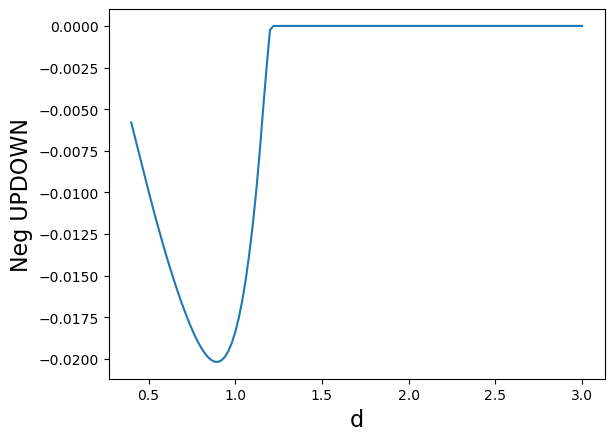

  0%|          | 0/131 [00:00<?, ?it/s]


IndexError: Index is not smaller than dimension 21 >= 21

In [26]:
import matplotlib.pyplot as plt

def plot_rho(vects, rho_arrays, label = r'$\rho^{(m)}$ eig'):
    ds = list(vects.keys())
    res = np.zeros(shape=(len(ds),rho_arrays.shape[0]))
    for idx, d in tqdm(enumerate(ds), total=len(ds)):
        vect = vects[d]
        rho = rho_m(vect, rho_arrays)
        res[idx] = np.sort(np.linalg.eigvals(rho.todense()))

    plt.plot(ds, res)
    plt.xlabel(r'd', fontsize=16)
    plt.ylabel(label, fontsize=16)
    plt.show()
    return res

def m_entropy(vects, rho_arrays):
    ds = list(vects.keys())
    res = np.zeros(shape=(len(ds)))
    for idx, d in tqdm(enumerate(ds), total=len(ds)):
        vect = vects[d]
        rho = rho_m(vect, rho_arrays)
        eigvals = np.sort(np.linalg.eigvals(rho.todense()))
        res[idx] = -np.sum([x * np.log2(x) for x in eigvals])
    return res / np.trace(rho.todense())

def plot_neg(vects, rho_arrays, label = r'$\rho^{(m)}$ eig'):
    ds = list(vects.keys())
    res = np.zeros(shape=(len(ds)))
    for idx, d in tqdm(enumerate(ds), total=len(ds)):
        vect = vects[d]
        rho = rho_m(vect, rho_arrays)
        rho = partial_traspose(rho, [0, 3, 2, 1]) - partial_traspose(rho, [0, 2, 3, 1])
        res[idx] = np.sum([x for x in np.linalg.eigvals(rho) if x<0])

    plt.plot(ds, res)
    plt.xlabel(r'd', fontsize=16)
    plt.ylabel(label, fontsize=16)
    plt.show()
    return res

#plot_rho(vects, rho_1_total_arrays, label = r'$\rho^{(1)}$ eig')
#plot_rho(vects, rho_2_total_arrays, label = r'$\rho^{(2)}$ eig')
#plot_rho(vects, rho_2_upup_arrays, label = r'$\rho^{(2)}_{upup}$ eig')
#plot_rho(vects, rho_2_updown_arrays, label = r'$\rho^{(2)}_{updown}$ eig')
plot_neg(vects, rho_2_extended, label = r'Neg UPDOWN')
#plot_neg(vects, rho_2_upup_arrays, label = r'Neg UPUP')

ds = list(vects.keys())
#plt.plot(ds, m_entropy(vects, rho_1_total_arrays),label='Total (1)')
#plt.plot(ds, m_entropy(vects, rho_2_total_arrays),label='Total (2)')
#plt.plot(ds, m_entropy(vects, rho_2_upup_arrays), label='UPUP')
#plt.plot(ds, m_entropy(vects, rho_2_updown_arrays), label='UPDOWN')
#plt.legend()
#plt.show()


Opt global

In [31]:
ds = list(vects.keys())[::10]
res = np.zeros(shape=(len(ds),3))
for idx, d in tqdm(enumerate(ds), total=len(ds)):
    loss = lambda au: np.linalg.norm(au, 1)
    vect = vects[d]
    # Estado sin transformar
    C = vect_to_tensor_array(basis, vect)
    res[idx,0] = loss(C)
    # Estado en base natural
    rho_up = C @ np.transpose(C)
    rho_down = np.transpose(C) @ C
    rho_1_up = rho_m(rho_up, rho_1_arrays)
    rho_1_down = rho_m(rho_down, rho_1_arrays)
    V_up = natural_basis_rotation(basis, rho_1 = rho_1_up)
    V_down = natural_basis_rotation(basis, rho_1 = rho_1_down)
    Cn = V_up @ C @ V_down.T
    res[idx,1] = loss(Cn)
    # Optimizamos
    expt_len = basis.d * (basis.d + 1) // 2
    triu_rows, triu_cols = np.triu_indices(basis.d)
    init_seed_up, init_seed_down = V_up[triu_rows, triu_cols], V_down[triu_rows, triu_cols]
    init_seed = np.concatenate([init_seed_up, init_seed_down])
    opt = scipy.optimize.minimize(opti_fun, init_seed, method='L-BFGS-B', options={'disp': True}, args=(C, basis))
    seed = opt.x
    seed_up, seed_down = seed[:expt_len], seed[expt_len:]
    Vop_up, Vop_down = seed_to_rotation(seed_up), seed_to_rotation(seed_down)
    Cop = Vop_up @ C @ Vop_down.T
    res[idx,2] = loss(Cop)

res = res.T

 14%|████████████████████████▊                                                                                                                                                     | 2/14 [08:03<48:23, 241.95s/it]


KeyboardInterrupt: 

In [162]:
import matplotlib.pyplot as plt
res = res.T
plt.pyplot.plot(ds, res[0], label='Estado')
plt.pyplot.plot(ds, res[1], label='Base natural')
plt.pyplot.plot(ds, res[2], label='Optimizado')
plt.pyplot.legend()

AttributeError: module 'matplotlib.pyplot' has no attribute 'pyplot'

In [13]:
norm1 = lambda au: np.sum(np.abs(au))
norm2 = lambda au: np.max

In [113]:
def cost(au):
    return np.linalg.norm(au, ord=1)

In [114]:
cost(C), cost(Cn), cost(Cop)

(0.6692917507771787, 0.6030561514836338, 0.6050418638279407)

In [37]:
np.trace(rhoo_up)

1.0000000406850609

Veamos que ocurre ahora con la matriz de coeficientes

In [30]:
cost = lambda au: np.max(np.sum(np.abs(au), axis=0))

In [31]:
cost(C), cost(Cn), cost(Cop)

(0.6692917507771787, 0.9191059397990166, 0.5485164931466948)

In [34]:
np.round(Cn,5).nonzero(), np.round(C,5).nonzero()

((array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,
          4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,
          5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,
          6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,
          9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
         10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
         11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
         12, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14,

In [36]:
np.linalg.norm(rho_up-rhon_up), np.linalg.norm(rho_up-rhoo_up)

(0.34206023774207855, 0.015398804494478627)

In [38]:
Cn

array([[-9.28164239e-03, -4.46010991e-02,  1.98770844e-03,
         1.12637076e-03,  4.83222874e-02,  2.09218992e-01,
        -6.87161227e-06, -2.94053351e-04,  9.19167665e-05,
        -8.81515231e-08,  9.98141372e-04,  4.44739298e-02,
         1.92547642e-01, -2.00574483e-04,  1.30140475e-06,
        -6.19631382e-06, -2.65156436e-04,  8.22383181e-05,
        -7.95612501e-08,  3.86674330e-11, -1.17359343e-06],
       [-2.02232733e-03,  1.43622010e-04,  2.09550437e-03,
         2.12130637e-01,  4.88637137e-03, -6.34054817e-04,
        -5.86450796e-05,  5.12685543e-06, -1.60728233e-07,
        -6.43177712e-04,  1.95228994e-01,  4.49727492e-03,
        -5.92258989e-04, -2.58660179e-05,  5.91937808e-04,
        -5.40017757e-05,  4.60137264e-06, -1.41186830e-07,
        -5.78547571e-04, -5.65948653e-07, -5.32456614e-04],
       [-4.55575504e-02,  3.96083234e-03, -2.62208130e-04,
         4.87186654e-03,  4.21116237e-01, -2.71044864e-02,
         2.21344247e-06,  3.59376282e-05, -6.51758419e

In [27]:
np.round(rhon_up,3)

array([[ 0.086,  0.001,  0.024, -0.016, -0.   ,  0.001,  0.   ,  0.   ,
        -0.   ,  0.   , -0.   ,  0.   , -0.   , -0.   ,  0.   , -0.   ,
        -0.   ,  0.   ,  0.   , -0.   ,  0.   ],
       [ 0.001,  0.083,  0.001, -0.007,  0.001, -0.   , -0.   , -0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.   , -0.   ,  0.   ,
         0.   , -0.   , -0.   ,  0.   , -0.   ],
       [ 0.024,  0.001,  0.332,  0.   , -0.002,  0.002,  0.   ,  0.   ,
        -0.   ,  0.   , -0.   , -0.   ,  0.   ,  0.   , -0.   , -0.   ,
         0.   ,  0.   , -0.   ,  0.   , -0.   ],
       [-0.016, -0.007,  0.   ,  0.333,  0.005, -0.   ,  0.   , -0.   ,
        -0.   ,  0.   ,  0.   , -0.   , -0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   , -0.   , -0.   , -0.   ],
       [-0.   ,  0.001, -0.002,  0.005,  0.083, -0.001, -0.   ,  0.   ,
        -0.   , -0.   ,  0.   ,  0.   ,  0.   , -0.   , -0.   ,  0.   ,
         0.   , -0.   ,  0.   , -0.   ,  0.   ],
       [ 0.001, -0.   ,  0.002, -0.

In [12]:
"""
Algunos casos de ejemplo para ver de como funciona la rotación de bases
"""
# Construimos la base reduciuda y la matriz C
C = vect_to_tensor_array(basis, vect)
# Calculamos las matrices de densidad reducidas UP, DOWN
rho_up = C @ np.transpose(C)
rho_down = np.transpose(C) @ C
# Calculo matrices densidad 1 cuerpo
rho_1_arrays = rho_m_gen(basis, 1)
rho_1_up = rho_m(rho_up, rho_1_arrays)
rho_1_down = rho_m(rho_down, rho_1_arrays)

V_up = natural_basis_rotation(basis, rho_1_up, rho_up)
rhot_up = V_up @ rho_up @ V_up.T
V_down = natural_basis_rotation(basis, rho_1_down, rho_down)
rhot_down = V_down @ rho_down @ V_down.T

np.linalg.eigvals(rho_m(rhot_up, rho_1_arrays).todense()), np.linalg.eigvals(rho_m(rhot_down, rho_1_arrays).todense())

100%|██████████| 21/21 [00:00<00:00, 23.98it/s]


(array([0.47487306, 0.52513204, 0.4806496 , 0.51935319, 0.99999489,
        0.99999739, 1.00000004]),
 array([0.47487306, 0.52513204, 0.4806496 , 0.51935319, 0.99999489,
        0.99999739, 1.00000004]))

In [34]:
np.trace(rhot_up)

1.000000040685061

In [73]:
print(opt)
print(opt.x)
print(sparsity_error(opt.x, k=k))
print(rho_2_obj)
np.round(r_eig(rho_m(opt.x, rho_2_arrays)),2)

  message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
  success: False
   status: 1
      fun: 0.033046434440661125
        x: [-3.375e-09 -6.560e-09 ... -2.341e-06 -2.501e-01]
      nit: 6
      jac: [ 2.845e-08 -2.429e-08 ... -3.317e-05 -3.462e-03]
     nfev: 16570
     njev: 10
 hess_inv: <1656x1656 LbfgsInvHessProduct with dtype=float64>
[-3.37476985e-09 -6.55962993e-09 -2.46507721e-09 ... -3.19263831e-09
 -2.34107673e-06 -2.50086415e-01]
0.03302971629150185
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11,
       0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11,
       0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.33, 0.33, 0.33, 0.33, 0.33,
       0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33,
       0.33, 0.33, 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ,
       0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ,
       0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ,
       0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ,
       0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.67, 0.67, 0.67, 0.67, 0.67,
       0.67, 0.67, 0.67, 0.67, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ])

In [94]:
final_res = of.FermionOperator.zero()

tol = 1e-3
for idx, coord in enumerate(opt.x):
    final_res += basis_pro.base[idx] * coord if np.abs(coord) > tol else 0
    if np.abs(coord) > tol:
        print((1/np.abs(coord)**2))

#final_res, unique_ele(final_res)
res_round = np.sum([basis_pro.base[idx] * 1/np.sqrt(np.round(1/coord**2)) for idx, coord in enumerate(opt.x) if np.abs(coord) > tol])
vect_round = op_to_rep(basis_pro, res_round)
r_eig(rho_m(vect_round, rho_1_arrays)), rho_1_obj


15.985149014125556
15.977994228992863
145.67794611307684
144.23635285020111
36.0667153166155
36.06669576174053
144.236519674107
145.67809058988465
15.940732217777308
15.92062248719232
36.06161200056504
144.19110686510734
145.6825136168376
144.3651909188651
36.137913817300415
144.15515590265179
36.08996734303805
146.12453205723767
145.9487386480123
36.0045807486866
143.95252252055505
145.46009050066652
145.68262967629167
144.19109509086093
36.06156842879171
146.12428332738412
145.94902938020775
36.13796198870655
144.36575578324243
36.089955665595035
144.15460190992823
145.46007040730746
143.95261481327165
36.00458940655681
15.941719440781728
15.91950923819659
145.45631237154984
143.99620720608377
36.00963579334049
36.009636612591606
143.99642927360614
145.45649058176977
15.951017099193605
15.988944628712272


(array([0.49947646, 0.49947646, 0.49947646, 0.49947646, 0.4995237 ,
        0.4995237 , 0.4995237 , 0.4995237 , 0.49957093, 0.49957093,
        0.49957093, 0.49957093, 0.99904739, 0.99904739, 0.99904739,
        0.99904739]),
 array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1. ,
        1. , 1. , 1. ]))

#### Testing

Verificamos que los eig de rho1 se preservan

In [34]:
# Cálculo de base natural
rho_1_arrays = rho_m_gen(basis, 1)
rho_1 = rho_m(vect, rho_1_arrays).todense()
evals, evects = scipy.linalg.eigh(rho_1)
C = evects

res, vect_op_ft = natural_basis_rotation(basis, C, vect)

ext_basis = fixed_basis(basis.d, basis.m)
rho_1_arrays_n = rho_m_gen(ext_basis, 1, num_workers=32)
rho_1_n = rho_m(res, rho_1_arrays_n).todense()
print(np.trace(rho_1_n), np.trace(rho_1))

evv = lambda vv: np.sort(np.real(np.linalg.eigvals(vv)))
print(evv(rho_1), evv(rho_1_n))

rep_to_op = lambda vect: np.sum([vect[i] * basis.base[i] for i in range(len(vect))])
#unique_ele(vect_op_ft), unique_ele(rep_to_op(vect))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:49<00:00,  1.54s/it]


10.000000000000002 10.000000406850612
[0.         0.         0.47487306 0.47487306 0.4806496  0.4806496
 0.51935319 0.51935319 0.52513204 0.52513204 0.99999489 0.99999489
 0.99999739 0.99999739 1.00000004 1.00000004] [0.         0.         0.47487306 0.47487306 0.48064955 0.48064955
 0.51935319 0.51935319 0.525132   0.525132   0.99999485 0.99999485
 0.99999735 0.99999735 1.         1.        ]


Verificamos que la composición, es la identidad

In [94]:
res, vect_op_ft = natural_basis_rotation(basis, C, vect)
res2, vect_op_ft2 = natural_basis_rotation(ext_basis, C.T, res)

vect_op = np.sum([vect[i] * basis.base[i] for i in range(len(vect))])

of.transforms.normal_ordered(vect_op_ft2), res2, of.transforms.normal_ordered(vect_op)

(-0.009493221505521588 [11^ 10^ 9^ 8^ 7^ 4^ 3^ 2^ 1^ 0^] +
 0.06567915392863352 [11^ 10^ 9^ 8^ 7^ 5^ 4^ 2^ 1^ 0^] +
 -0.00039479040463999686 [11^ 10^ 9^ 8^ 7^ 5^ 4^ 3^ 2^ 0^] +
 -3.372243029427183e-06 [11^ 10^ 9^ 8^ 7^ 5^ 4^ 3^ 2^ 1^] +
 -0.046493134167591176 [11^ 10^ 9^ 8^ 7^ 6^ 3^ 2^ 1^ 0^] +
 -0.28426333153569405 [11^ 10^ 9^ 8^ 7^ 6^ 5^ 2^ 1^ 0^] +
 -0.00013174919476567257 [11^ 10^ 9^ 8^ 7^ 6^ 5^ 3^ 2^ 0^] +
 3.4219639201432875e-07 [11^ 10^ 9^ 8^ 7^ 6^ 5^ 3^ 2^ 1^] +
 0.002101619231354521 [12^ 10^ 9^ 8^ 7^ 5^ 3^ 2^ 1^ 0^] +
 0.2881444085777637 [12^ 10^ 9^ 8^ 7^ 6^ 4^ 2^ 1^ 0^] +
 -7.974636812387609e-05 [12^ 10^ 9^ 8^ 7^ 6^ 4^ 3^ 2^ 0^] +
 -2.402101031541447e-06 [12^ 10^ 9^ 8^ 7^ 6^ 4^ 3^ 2^ 1^] +
 0.0011760974915812092 [12^ 10^ 9^ 8^ 7^ 6^ 5^ 4^ 2^ 0^] +
 8.012654141343571e-06 [12^ 10^ 9^ 8^ 7^ 6^ 5^ 4^ 2^ 1^] +
 5.654427524408164e-07 [12^ 10^ 9^ 8^ 7^ 6^ 5^ 4^ 3^ 2^] +
 0.06567916523926123 [12^ 11^ 9^ 8^ 7^ 4^ 3^ 2^ 1^ 0^] +
 0.00389332162644885 [12^ 11^ 9^ 8^ 7^ 5^ 4^ 2^ 1^ 0^] +


Funciones auxiliares

In [99]:
def unique_ele(op):
    terms = list(op.terms.items())
    act_idx = lambda tt: [i[0] for i in tt[0]]
    terms_set = []
    for term in terms:
        if np.abs(term[1]) > 1e-6:
            terms_set.append(act_idx(term))
    return set(terms_set[0]).intersection(*terms_set[1:])

unique_ele(op_pro), unique_ele(op_fund)

(set(), set())

In [50]:
np.linalg.eigvals(rho_1)

array([0.97351211, 0.92118047, 0.31511585, 0.31511585, 0.79019157,
       0.79019157, 1.        , 0.97351211, 0.92118047, 1.        ,
       1.        , 1.        ])

In [ ]:
# Verifiquemos que los orbitales son ortogonales
op_arr = np.zeros((basis.d,basis.d),dtype=object)
sp_basis = fixed_basis(basis.d, 1)
for i in tqdm(range(basis.d)):
    for j in range(basis.d):
        oi = np.real(of.get_sparse_operator(targ_sp[i], n_qubits=basis.d))
        oj = np.real(of.get_sparse_operator(targ_sp[j], n_qubits=basis.d))
        # Sin daguear y dagueado
        assert len((oi * oj + oj * oi).data) == 0
        assert len((oi.T * oj.T + oj.T * oi.T).data) == 0
        # Términos cruzados
        op_arr[i,j] = oi * oj.T + oj.T * oi
        sh = op_arr[i,j].shape[0]
        if i != j:
            assert np.allclose(np.zeros((sh,sh)),op_arr[i,j].todense())
        else:
            assert np.allclose(np.eye(sh),op_arr[i,j].todense())

100%|██████████| 12/12 [01:00<00:00,  5.07s/it]


In [32]:
est = 0
app_r = lambda x: np.round(1/(x**2), 0)
for i, ii in enumerate(opt.x):
    if np.abs(ii) > 0.1:
        print(i, ii, basis.base[i])
        if np.abs(ii) > 0.2:
            print(app_r(ii))
            est += 1/np.sqrt(app_r(ii)) * basis.canonicals[i]
            print('')

#(1/np.sqrt(3), 1/np.sqrt(12))
#print(est)
est = 1/np.sqrt(12) * (-basis.canonicals[5]+basis.canonicals[25]+basis.canonicals[85]-basis.canonicals[105])+1/np.sqrt(3)*(basis.canonicals[45]+basis.canonicals[65])

print(r_eig(rho_m(est, rho_2_arrays)))


5 -0.27936976320734497 1.0 [0^ 1^ 2^ 3^ 4^ 7^ 8^ 9^ 12^ 13^]
13.0

25 0.28996316812175205 1.0 [0^ 1^ 2^ 3^ 5^ 7^ 8^ 9^ 11^ 13^]
12.0

45 0.5718530568911167 1.0 [0^ 1^ 2^ 3^ 6^ 7^ 8^ 9^ 11^ 12^]
3.0

65 0.572154480816062 1.0 [0^ 1^ 2^ 4^ 5^ 7^ 8^ 9^ 10^ 13^]
3.0

85 0.2897326805359033 1.0 [0^ 1^ 2^ 4^ 6^ 7^ 8^ 9^ 10^ 12^]
12.0

105 -0.27954194550717076 1.0 [0^ 1^ 2^ 5^ 6^ 7^ 8^ 9^ 10^ 11^]
13.0

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.5
 0.5        0.5        0.5        0.5        0

In [259]:
r_eig(rho_m(vect, rho_2_arrays))

array([6.39649654e-18, 2.27759896e-17, 2.27759896e-17, 2.97340303e-17,
       1.05847838e-08, 1.05847839e-08, 8.12469946e-02, 8.12469946e-02,
       8.12469946e-02, 8.12469946e-02, 8.12469946e-02, 8.12469946e-02,
       8.26670825e-02, 8.26670825e-02, 8.26670825e-02, 8.26670825e-02,
       8.26670825e-02, 8.26670825e-02, 3.36085923e-01, 3.36085923e-01,
       3.36085923e-01, 3.36085923e-01, 3.36085923e-01, 3.36085923e-01,
       7.48001237e-01, 7.48001237e-01, 7.51998753e-01, 7.51998753e-01])

#### Testing

In [256]:
vect = [-4.646928018967011e-01,2.770294629368069e-13,6.042253100720720e-13,-6.024516357133285e-13,-2.567187786718633e-13,1.437594192304828e-01,-2.763730452330614e-13,4.646928018967681e-01,6.783135520862164e-13,6.755585098225312e-13,-1.437594192304206e-01,2.565069368880155e-13,-6.036534951757788e-13,-6.777043000828106e-13,-6.255919748617283e-14,-2.875188384604817e-01,-6.292320178844996e-13,-5.606330583371935e-13,6.014298958703158e-13,-6.759194003610720e-13,-2.875188384604817e-01,-6.207393804663961e-14,-6.269833844031960e-13,5.590088393571927e-13,2.557458444682729e-13,-1.437594192304207e-01,6.287588334290853e-13,6.270036860946324e-13,4.000749631766127e-01,-2.383049928519640e-13,1.437594192304827e-01,-2.559215089660516e-13,5.600763473792744e-13,-5.580405389843103e-13,2.382296361695720e-13,-4.000749631765536e-01]
vect = np.array(vect)
vect

array([-4.64692802e-01,  2.77029463e-13,  6.04225310e-13, -6.02451636e-13,
       -2.56718779e-13,  1.43759419e-01, -2.76373045e-13,  4.64692802e-01,
        6.78313552e-13,  6.75558510e-13, -1.43759419e-01,  2.56506937e-13,
       -6.03653495e-13, -6.77704300e-13, -6.25591975e-14, -2.87518838e-01,
       -6.29232018e-13, -5.60633058e-13,  6.01429896e-13, -6.75919400e-13,
       -2.87518838e-01, -6.20739380e-14, -6.26983384e-13,  5.59008839e-13,
        2.55745844e-13, -1.43759419e-01,  6.28758833e-13,  6.27003686e-13,
        4.00074963e-01, -2.38304993e-13,  1.43759419e-01, -2.55921509e-13,
        5.60076347e-13, -5.58040539e-13,  2.38229636e-13, -4.00074963e-01])

In [167]:
np.sort(np.linalg.eigvals(rho_m(vect, rho_2_arrays).todense()))

array([6.39649654e-18+0.00000000e+00j, 2.27759896e-17-1.60872919e-17j,
       2.27759896e-17+1.60872919e-17j, 2.97340303e-17+0.00000000e+00j,
       1.05847838e-08+0.00000000e+00j, 1.05847839e-08+0.00000000e+00j,
       8.12469946e-02+0.00000000e+00j, 8.12469946e-02+0.00000000e+00j,
       8.12469946e-02+0.00000000e+00j, 8.12469946e-02+0.00000000e+00j,
       8.12469946e-02+0.00000000e+00j, 8.12469946e-02+0.00000000e+00j,
       8.26670825e-02+0.00000000e+00j, 8.26670825e-02+0.00000000e+00j,
       8.26670825e-02+0.00000000e+00j, 8.26670825e-02+0.00000000e+00j,
       8.26670825e-02+0.00000000e+00j, 8.26670825e-02+0.00000000e+00j,
       3.36085923e-01+0.00000000e+00j, 3.36085923e-01+0.00000000e+00j,
       3.36085923e-01+0.00000000e+00j, 3.36085923e-01+0.00000000e+00j,
       3.36085923e-01+0.00000000e+00j, 3.36085923e-01+0.00000000e+00j,
       7.48001237e-01+0.00000000e+00j, 7.48001237e-01+0.00000000e+00j,
       7.51998753e-01+0.00000000e+00j, 7.51998753e-01+0.00000000e+00j])